# Dynamic Ride Pricing

In [1]:
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings('ignore')  # Disabling warning outputs

# Loading Data

In [2]:
TRAIN_DATAPATH = "C:/Users/prane/Downloads/dynamic_pricing/dynamic_pricing.csv" 
df = pd.read_csv(TRAIN_DATAPATH)  
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [3]:
shape = df.shape
print(shape)

(1000, 10)


# <a id='second'></a> Data Preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB


In [5]:
df.isna().sum()

Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

In [6]:
df.dtypes

Number_of_Riders             int64
Number_of_Drivers            int64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides         int64
Average_Ratings            float64
Time_of_Booking             object
Vehicle_Type                object
Expected_Ride_Duration       int64
Historical_Cost_of_Ride    float64
dtype: object

In [7]:
df.duplicated().value_counts()

False    1000
dtype: int64

In [8]:
df.columns

Index(['Number_of_Riders', 'Number_of_Drivers', 'Location_Category',
       'Customer_Loyalty_Status', 'Number_of_Past_Rides', 'Average_Ratings',
       'Time_of_Booking', 'Vehicle_Type', 'Expected_Ride_Duration',
       'Historical_Cost_of_Ride'],
      dtype='object')

# <a id='third'></a> Exploratory Data Analysis

In [9]:
df.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [10]:
df.describe(include='object')

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
count,1000,1000,1000,1000
unique,3,3,4,2
top,Urban,Silver,Night,Premium
freq,346,367,276,522


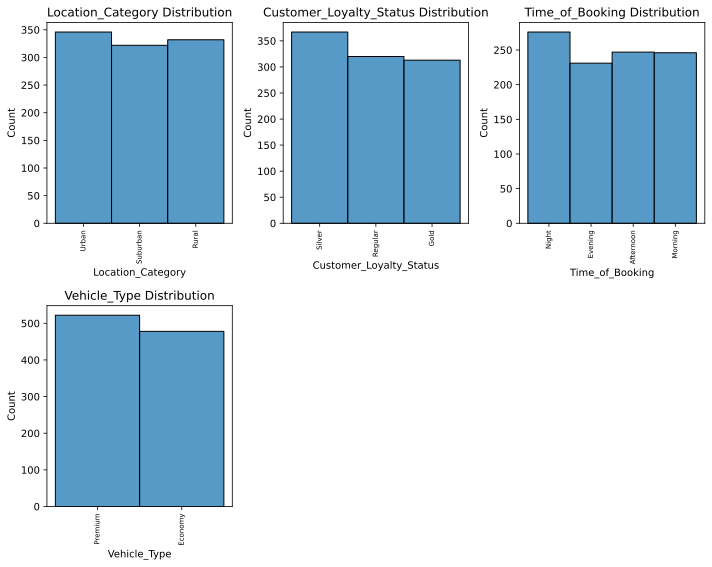

In [11]:
categorical_cols = df.select_dtypes(include=['object']).columns
num_plots = len(categorical_cols)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)
plt.figure(figsize=(10, 4 * num_rows))
for i, col in enumerate(df[categorical_cols], 1):
    mode = df[col].mode()[0]    
    plt.subplot(num_rows, num_columns, i)
    sns.histplot(df[col]) 
    plt.xticks(rotation=90, fontsize=7) 
    plt.title(f'{col} Distribution') 
plt.tight_layout()
plt.show() 

### Outliers and Inconsistent Data

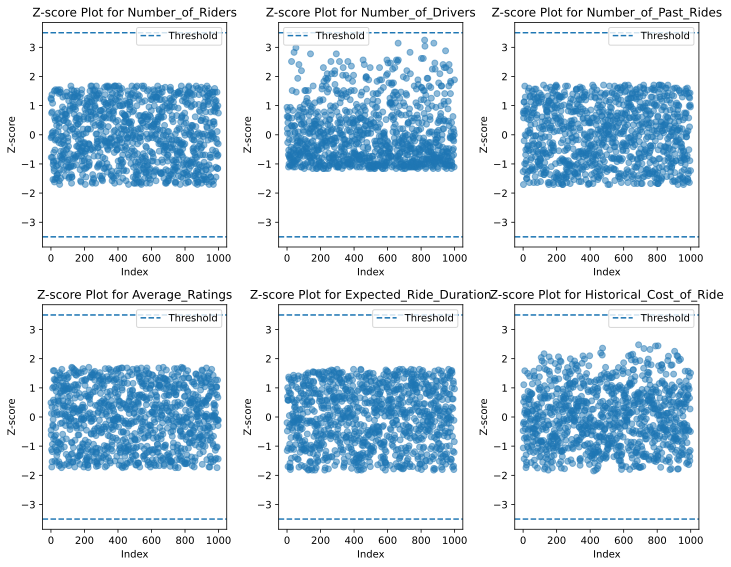

In [12]:
numerics = df.select_dtypes(include=np.number)
num_plots = len(numerics.columns)
num_columns = 3
num_rows = num_plots // num_columns + (1 if num_plots % num_columns > 0 else 0)
plt.figure(figsize=(10, 4 * num_rows))
for i, col in enumerate(numerics, 1):
    plt.subplot(num_rows, num_columns, i)  
    z_scores = (numerics[col] - numerics[col].mean()) / numerics[col].std()
    threshold = 3.5
    plt.scatter(np.arange(len(z_scores)), z_scores, alpha=0.5)
    plt.axhline(y=threshold, linestyle='--', label='Threshold')
    plt.axhline(y=-threshold, linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Z-score')
    plt.title(f'Z-score Plot for {col}')
    plt.legend()
plt.tight_layout()
plt.show()

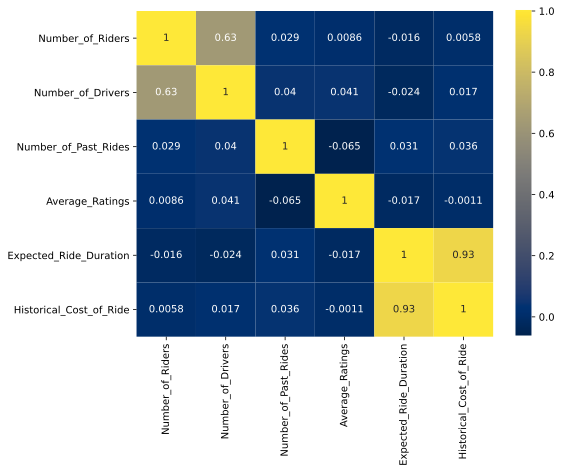

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='cividis')
plt.show()

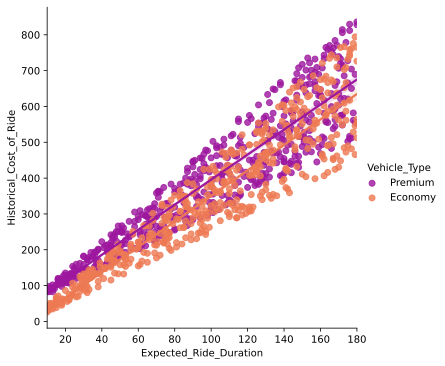

In [14]:
sns.lmplot(data=df, y='Historical_Cost_of_Ride', x='Expected_Ride_Duration', hue='Vehicle_Type', palette='plasma')
plt.show()

# <a id='fifth'></a> Feature Engineering

In [15]:
# Calculate demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                   df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile))
high_supply_percentile = 75
low_supply_percentile = 25
df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'], low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile)/ df['Number_of_Drivers'], 
                                   np.percentile(df['Number_of_Drivers'], low_supply_percentile) / df['Number_of_Drivers'])
demand_threshold_high = 1.2  # Higher demand threshold
demand_threshold_low = 0.8  # Lower demand threshold
supply_threshold_high = 0.8  # Higher supply threshold
supply_threshold_low = 1.2  # Lower supply threshold

# Calculate adjusted_ride_cost for dynamic pricing
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * (
    np.maximum(df['demand_multiplier'], demand_threshold_low) *
    np.maximum(df['supply_multiplier'], supply_threshold_high)
)

In [16]:
df.head(10)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,266.710528
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,245.653817
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,424.478684
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,701.155452
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,1952.472427
5,59,35,Urban,Silver,83,3.51,Night,Economy,128,339.955361,1.475000,1.085714,544.414227
6,93,43,Suburban,Regular,44,4.41,Afternoon,Premium,16,104.061541,1.148148,0.883721,105.585268
7,62,39,Rural,Gold,83,3.59,Afternoon,Premium,47,235.811864,1.550000,0.974359,356.136379
8,79,14,Rural,Silver,71,3.74,Evening,Economy,128,501.412517,1.975000,2.714286,2687.929246
9,42,6,Rural,Silver,21,3.85,Night,Premium,128,398.993365,1.050000,1.833333,768.062227


In [17]:
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
profitable_rides = df[df['profit_percentage'] > 0]
loss_rides = df[df['profit_percentage'] < 0]

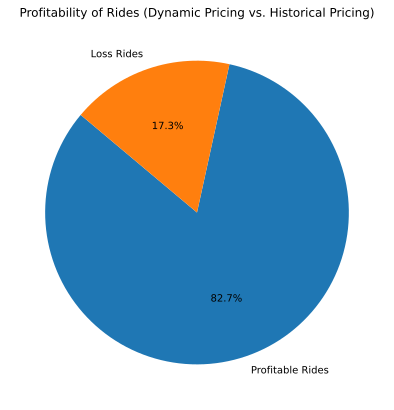

In [18]:
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) 
                           / df['Historical_Cost_of_Ride']) * 100
profitable_rides = df[df['profit_percentage'] > 0]
loss_rides = df[df['profit_percentage'] < 0]
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')
plt.show()

In [19]:
#Log normalization
df['adjusted_ride_cost'] = np.log1p(df['adjusted_ride_cost'])

In [20]:
#Box-Cox Transformation for Skewed Features
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

# <a id='sixth'></a> Data Splitting

In [21]:
TARGET = df['adjusted_ride_cost']
df = df.drop(columns=['adjusted_ride_cost'])

In [22]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})
X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]
coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)
poly = np.poly1d(coefficients)
division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)
X['interpolated_division'] = pd.Series(division_feature)

In [23]:
y = TARGET
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Model Training

In [25]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}
params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

def train_model(model, params, X_train, y_train):
    pipeline = Pipeline([
        ('model', model)
    ])
    if params:
        params = {f'model__{key}': value for key, value in params.items()}
        grid_search = GridSearchCV(pipeline, params, cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(X_train, y_train)
        return grid_search
    else:
        pipeline.fit(X_train, y_train)
        return pipeline

def predict(model, X_test):
    return model.predict(X_test)

def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2

results = []
for name, model in models.items():
    params = params.get(name, {})
    trained_model = train_model(model, params, X_train, y_train)
    y_pred = predict(trained_model, X_test)
    mse, rmse, r2 = evaluate_model(y_test, y_pred)
    results.append({
        'Model': name,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse,
        'R-Squared': r2,
    })
results_df = pd.DataFrame(results)

# <a id='eighth'></a> Model Evaluation

In [28]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.5f}'.format)
results_df

,Model,Mean Squared Error,Root Mean Squared Error,R-Squared
0,Ridge,0.20378,0.45142,0.66655
1,Lasso,0.61186,0.78221,-0.00118
2,SVR,0.09100,0.30167,0.85109
3,RandomForestRegressor,0.05194,0.22790,0.91501
4,XGBRegressor,0.05005,0.22371,0.91811
5,CatBoostRegressor,0.03357,0.18321,0.94507


In [29]:
model = CatBoostRegressor(verbose=0)
model.fit(X_train, y_train)
model.score(X_test, y_test)
preds = model.predict(X_test)
r2 = r2_score(y_test, preds)
print(f"R-squared (R2): {r2}")
feature_coefficients = pd.DataFrame(model.feature_importances_, index=X.columns,
                                    columns=['Importance']).sort_values(by='Importance', ascending=False)
print(feature_coefficients)
df.head()

R-squared (R2): 0.9450741482117736
                        Importance
Expected_Ride_Duration    46.66251
Number_of_Drivers         30.42825
Number_of_Riders          11.24991
interpolated_division      8.18864
Vehicle_Type               3.47070


,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,profit_percentage
0,90,4.17833,Urban,Silver,13,4.47000,Night,1,90,284.25727,1.11111,0.84444,-6.17284
1,58,4.01281,Suburban,Silver,72,4.06000,Evening,0,43,173.87475,1.45000,0.97436,41.28205
2,42,3.75068,Rural,Silver,0,3.99000,Afternoon,1,76,329.79547,1.05000,1.22581,28.70968
3,89,3.63587,Rural,Regular,67,4.31000,Afternoon,1,134,470.20123,1.09877,1.35714,49.11817
4,78,3.36754,Rural,Regular,74,3.77000,Afternoon,0,149,579.68142,1.95000,1.72727,236.81818


# Prediction

In [30]:
def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric
  
def predict_price(number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    number_of_riders = np.array(number_of_riders)
    number_of_drivers = np.array(number_of_drivers)
    coefficients = np.polyfit(number_of_riders.ravel(), number_of_drivers.ravel(), deg=2)
    poly = np.poly1d(coefficients)
    division_feature = poly(number_of_riders / number_of_drivers)
    input_data = np.array([number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type_numeric, division_feature])
    input = pd.DataFrame(input_data.reshape(1, -1))
    scaled_input_data = scaler.transform(input)
    predicted_price = model.predict(scaled_input_data)
    return predicted_price

user_number_of_riders = 85
user_number_of_drivers = 65
user_vehicle_type = "Premium"
Expected_Ride_Duration = 165
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, Expected_Ride_Duration, user_vehicle_type)
print("Predicted price:", np.expm1(predicted_price))

Predicted price: [698.04066391]
